# Numeric Inverse Kinematics

In [164]:
import numpy as np

In [168]:
def get_angles(x, y, z, phi3, theta3, r1=1, r2=1, r3=1):
    phi1 = np.arctan2(-r3*np.sin(phi3)*np.sin(theta3)+y, -r3*np.sin(theta3)*np.cos(phi3)+x)
    
    # 
    a3 = np.array([r3*np.sin(theta3)*np.cos(phi3),
                   r3*np.sin(theta3)*np.sin(phi3),
                   r3*np.cos(theta3)])
    x3 = np.array([x, y, z])
    x2 = x3 - a3
    
    x2d = np.sqrt(x2[0]**2 + x2[1]**2 + x2[2]**2)
    p2d = np.sqrt(x2[0]**2 + x2[1]**2)
    
    theta1 = np.pi/2 - np.arccos(p2d/x2d) - np.arccos((x2d**2 + r1**2 - r2**2) / (2*x2d*r1))
    dtheta2 = np.pi - np.arccos((r1**2+r2**2-x2d**2)/(2*r1*r2))
    theta2 = theta1 + dtheta2
    
    dtheta3 = np.arctan2((np.sqrt(r3**2*( (np.sin(theta2)*np.cos(theta3)-np.sin(theta3)*np.cos(theta2)*np.cos(phi1-phi3))**2 + (np.sin(theta3)**2 * np.sin(phi1-phi3)**2) ))),
                        (r3 * (np.sin(theta2)*np.sin(theta3)*np.cos(phi1-phi3) + np.cos(theta2)*np.cos(theta3))))
    
    
    
    py = -r3*np.sin(theta3)*np.sin(phi1-phi3)
    px = -r3*np.sin(theta3)*np.sin(phi1-phi3)
    dphi3 = np.arctan2(py, px)

    return theta1, dtheta2, dtheta3, phi1, dphi3


f = 50
z = np.zeros(f) + 0.1
i = np.linspace(0, np.pi*2, f)
x = 1.5*np.cos(i)
y = 1.5*np.sin(i)
phi = theta = np.zeros(f)

th1, th2, th3, phi1, phi3 = get_angles(x, y, z, phi, theta)





# Numeric Forward Kinematics

In [169]:
import sympy as sp
r1, r2, r3, th1, th2, th3, phi1, phi2 = sp.symbols("r_1 r_2 r_3 theta_1 theta_2 theta_3 phi_1 phi_2")
get_z_rot_mat = lambda phi: sp.Matrix([[sp.cos(phi), -sp.sin(phi), 0],[sp.sin(phi), sp.cos(phi), 0],[0, 0, 1]])
get_y_rot_mat = lambda th: sp.Matrix([[sp.cos(th), 0, sp.sin(th)],[0, 1, 0],[-sp.sin(th), 0, sp.cos(th)]])
dX1 = sp.Matrix([r1*sp.sin(th1)*sp.cos(phi1),r1*sp.sin(th1)*sp.sin(phi1),r1*sp.cos(th1)])
lam_dX1 = sp.lambdify([r1, th1, phi1], dX1, "numpy")
dX2p = sp.Matrix([r2*sp.sin(th2),0,r2*sp.cos(th2)]); dX2p
dX2 = sp.trigsimp((get_y_rot_mat(-th1) * get_z_rot_mat(-phi1)).inv() * dX2p)
lam_dX2 = sp.lambdify([r1, r2, th1, th2, phi1], dX2, "numpy")
dX3p = sp.Matrix([r3*sp.sin(th3)*sp.cos(phi2),r3*sp.sin(th3)*sp.sin(phi2),r3*sp.cos(th3)])
dX3 = sp.trigsimp((get_y_rot_mat(-(th1+th2)) * get_z_rot_mat(-phi1)).inv() * dX3p)
lam_dX3 = sp.lambdify([r1, r2, r3, th1, th2, th3, phi1, phi2], dX3, "numpy")

In [170]:
def arm_coords(th1, th2, th3, phi1, phi2, r1=1, r2=1, r3=1):
    # get change in position of each arm
    arm_1_coords = lam_dX1(r1, th1, phi1)[:,0,:].T
    d_arm_2_coords = lam_dX2(r1, r2, th1, th2, phi1)[:,0,:].T
    d_arm_3_coords = lam_dX3(r1, r2, r3, th1, th2, th3, phi1, phi2)[:,0,:].T

    # get absolute position of each arm
    arm_2_coords = arm_1_coords + d_arm_2_coords
    arm_3_coords = arm_2_coords + d_arm_3_coords

    # format output for animation
    x_points = np.array([np.zeros(len(th1)), arm_1_coords[:, 0], arm_2_coords[:, 0], arm_3_coords[:, 0]]).T
    y_points = np.array([np.zeros(len(th1)), arm_1_coords[:, 1], arm_2_coords[:, 1], arm_3_coords[:, 1]]).T
    z_points = np.array([np.zeros(len(th1)), arm_1_coords[:, 2], arm_2_coords[:, 2], arm_3_coords[:, 2]]).T

    return x_points, y_points, z_points

In [179]:
x_points, y_points, z_points = arm_coords(th1, th2, th3, phi1, phi3)

# Animation

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

In [ ]:
def animate_5dof(x_points, y_points, z_points, thAs=None, thBs=None, thCs=None, thDs=None, thEs=None):
    if not (thAs is None or thBs is None or thCs is None or thDs is None or thEs is None):
        big_plot = True
        thAs, thBs, thCs, thDs, thEs = thAs*180/np.pi, thBs*180/np.pi, thCs*180/np.pi, thDs*180/np.pi, thEs*180/np.pi
    else:
        big_plot=False

    # get bounds for marker sizes
    size_bounds_x = [np.min(np.min(x_points, axis=1)).round(5), np.max(np.max(x_points, axis=1)).round(5)]
    size_bounds_z = [np.min(np.min(z_points, axis=1)).round(5), np.max(np.max(z_points, axis=1)).round(5)]
    size_bounds_y = [np.min(np.min(y_points, axis=1)).round(5), np.max(np.max(y_points, axis=1)).round(5)]


    # the animation
    if big_plot:
        fig = plt.figure(figsize=(12, 12))
        ax1 = plt.subplot(2,2,1)
        ax2 = plt.subplot(2,2,2)
        ax3 = plt.subplot(2,1,2)

        ax3.set_xlim([0, len(thAs)])
        ax3.set_ylim([np.min([np.min(thCs), np.min(thAs), np.min(thBs)]), np.max([np.max(thCs), np.max(thAs), np.max(thBs)])])
        ax3.plot(thAs[:1], label="$\\theta_1$")
        ax3.plot(thBs[:1], label="$\\theta_2$")
        ax3.plot(thCs[:1], label="$\\theta_3$")
        ax3.plot(thDs[:1], label="$\\phi_1$")
        ax3.plot(thEs[:1], label="$\\phi_3$")
        ax3.legend()
        ax3.set_title("Motor Angles")
        ax3.set_xlabel("Time")
        ax3.set_ylabel("Motor Angle (degrees)")
    else:
        fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

    def construct_frame(i):
        xpoints = x_points[i,:]
        ypoints = y_points[i,:]
        zpoints = z_points[i,:]

        # Side on view of the robot
        ax1.clear()
        ax1.set_xlim([-3.5, 3.5])
        ax1.set_ylim([-3.5, 3.5])
        ax1.plot(xpoints, zpoints, linewidth=5, color="black", zorder=1)
        ax1.plot(0, 0, 's', markersize=20, color="red", zorder=2)
        ax1.scatter(x=xpoints[1:], y=zpoints[1:], s=np.interp(ypoints[1:], size_bounds_y, [500, 100]), c=["green", "blue", "orange"], zorder=3)
        ax1.set_xlabel("Position, x")
        ax1.set_ylabel("Position, z")
        ax1.set_title("Side View")

        # top down view of the robot
        ax2.clear()
        ax2.set_xlim([-3.5, 3.5])
        ax2.set_ylim([-3.5, 3.5])
        ax2.plot(xpoints, ypoints, linewidth=5, color="black", zorder=2)
        ax2.plot(0, 0, marker=(4, 0, 45-(180/np.pi)*np.arctan2(xpoints[1], ypoints[1])), markersize=30, color="red", zorder=1)
        ax2.scatter(x=xpoints[1:], y=ypoints[1:], s=np.interp(zpoints[1:], size_bounds_z, [100, 500]), c=["green", "blue", "orange"], zorder=3)
        ax2.set_title("Plan View")
        ax2.set_xlabel("Position, x")
        ax2.set_ylabel("Position, y")

        if big_plot:
            # log of motor positions
            ax3.plot(thAs[:i], label="$\\theta_a$", color="blue")
            ax3.plot(thBs[:i], label="$\\theta_b$", color="orange")
            ax3.plot(thCs[:i], label="$\\theta_c$", color="green")

    # set ani variable to call the
    # function recursively
    anim = FuncAnimation(fig, construct_frame, interval=1, frames=len(x_points[:,1]))
    anim.save("out.mp4", fps=24)

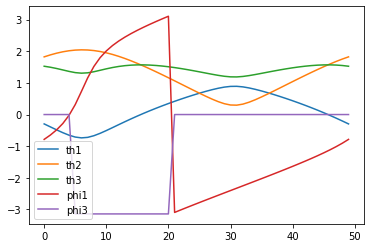

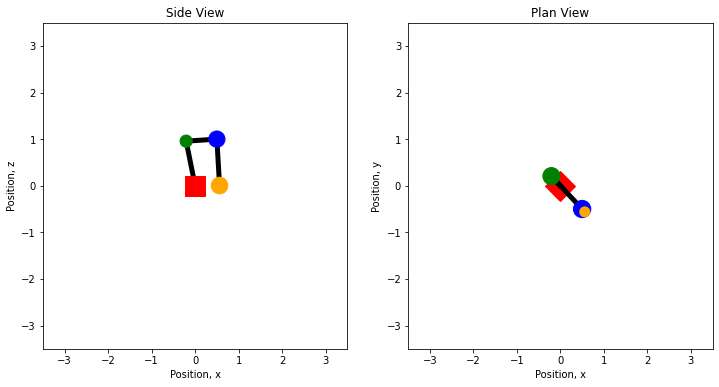

In [184]:
f = 50
z = np.zeros(f) + 2
i = np.linspace(0, np.pi*2, f)
x = np.cos(i)-0.5
y = np.sin(i)-0.5
phi = theta = np.zeros(f)
theta = np.zeros(f)


th1, th2, th3, phi1, phi3 = get_angles(x, y, z, phi, theta)
x_points, y_points, z_points = arm_coords(th1, th2, th3, phi1, phi3)

plt.plot(th1, label="th1")
plt.plot(th2, label="th2")
plt.plot(th3, label="th3")
plt.plot(phi1, label="phi1")
plt.plot(phi3, label="phi3")
plt.legend()
plt.show()

animate_5dof(x_points, y_points, z_points)



